Librerías necesarias 

In [1]:
import pandas as pd
import networkx as nx
import json
from pprint import pprint

import overpy
import folium
import os
import math
import numpy as np
from pathlib import Path
from rapidfuzz import process, fuzz


Ecuaciones de distancias

In [13]:
def haversine_m(lat1, lon1, lat2_arr, lon2_arr):
    R = 6371000.0
    p1 = np.radians(lat1); p2 = np.radians(lat2_arr)
    dlat = p2 - p1
    dlon = np.radians(lon2_arr) - np.radians(lon1)
    a = np.sin(dlat/2)**2 + np.cos(p1)*np.cos(p2)*np.sin(dlon/2)**2
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R*c

def numerable(df, cols):
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df


# Base de datos
### GTFS Ciudad de México
General Transit Feed Specification Ciudad de México
### DENUE INEGI
Contiene archivos de razón comercial de la ciudad de México, ya están filtrados por el codigo de sector de salud (62)
### Hospitales, clinicas y dentistas de OSM
Base de datos con OpenStreetMaps y pandas :D

In [ ]:
code = "622112"  # de actividad económica (código INEGI)
file = Path("denue_by_codigo") / f"{code}.csv"
assert file.exists(), f"File not found: {file}"

df = pd.read_csv(file, dtype=str)
print("Renglones:", len(df))
print("Columnas:", df.columns.tolist())

df["lat"] = pd.to_numeric(df["lat"], errors="coerce")
df["lon"] = pd.to_numeric(df["lon"], errors="coerce")
df = df.dropna(subset=["lat","lon"])
print("Renglones con coordenadas válidas:", len(df))


in_cdmx = (df["lat"].between(18.9, 19.9)) & (df["lon"].between(-100.0, -98.5))
pct_in_bounds = in_cdmx.mean() * 100
print(f"¿Jala? %: {pct_in_bounds:.1f}%")

if pct_in_bounds < 10:
    df_swapped = df.rename(columns={"lat":"lon_tmp", "lon":"lat"}).rename(columns={"lon_tmp":"lon"})
    df_swapped["lat"] = pd.to_numeric(df_swapped["lat"], errors="coerce")
    df_swapped["lon"] = pd.to_numeric(df_swapped["lon"], errors="coerce")
    in_cdmx_swapped = (df_swapped["lat"].between(18.9, 19.9)) & (df_swapped["lon"].between(-100.0, -98.5))
    pct_swapped = in_cdmx_swapped.mean() * 100
    print(f"In-bounds after swap %: {pct_swapped:.1f}%")
    if pct_swapped > pct_in_bounds:
        df = df_swapped
        print(">> Using SWAPPED lat/lon (data seemed inverted).")

df_diag = df.copy()
df_diag.head()


Una vista a como queda el mapa 

In [ ]:
from folium.plugins import MarkerCluster

m2 = folium.Map(location=[19.4326, -99.1332], zoom_start=11, tiles="OpenStreetMap")
cluster = MarkerCluster(disableClusteringAtZoom=15)

for _, r in df_diag.iterrows():
    folium.Marker(
        location=(float(r["lat"]), float(r["lon"])),
        popup=folium.Popup(f"<b>{r.get('name','Sin nombre')}</b><br>SCIAN: {code}", max_width=300),
        icon=folium.Icon(color="red", icon="plus-sign", prefix="glyphicon")
    ).add_to(cluster)

cluster.add_to(m2)
folium.LayerControl(collapsed=False).add_to(m2)
m2.save("mapita.html")


In [3]:
# GTFS
agencia = pd.read_csv("gtfs-2/agency.txt", dtype=str)
calendario = pd.read_csv("gtfs-2/calendar.txt", dtype=str)
frecuencia = pd.read_csv("gtfs-2/frequencies.txt",dtype=str)
rutas = pd.read_csv("gtfs-2/routes.txt",dtype=str)
formas = pd.read_csv("gtfs-2/shapes.txt",dtype=str)
tiempo_paradas = pd.read_csv("gtfs-2/stop_times.txt",dtype=str)
paradas = pd.read_csv("gtfs-2/stops.txt",dtype=str)
viajes = pd.read_csv("gtfs-2/trips.txt",dtype=str)

paradas = numerable(paradas, ["stop_lat","stop_lon"])

# Hospitales, clínicas y dentistas de OSM
hospis = pd.read_csv("Hospiclin_CDMX.csv")

In [4]:
# Selección de archivos DENUE
FAC_DIR = Path("denue_by_codigo")

def _escoger_col(df, candidatos):
    # busca exacto y luego insensible a mayúsculas
    for c in candidatos:
        if c in df.columns: return c
    low = {c.lower(): c for c in df.columns}
    for c in candidatos:
        if c.lower() in low: return low[c.lower()]
    return None


def hospis_df(codigos=None, por_prefijo=False):
    """
    Lee archivos de denue_by_codigo y devuelve un DF normalizado:
    columnas: facility_id, codigo_act, nombre, name, lat, lon, fuente
    - codigos: None | str | int | list[str]; si por_prefijo=True y el código < 6 dígitos, usa glob por prefijo.
    """
    # Normalizar 'codigos' a lista
    if codigos is None:
        files = [p for p in FAC_DIR.glob("*.csv") if p.name != "_index_by_codigo.csv"]
    else:
        if isinstance(codigos, (str, int)):
            codigos = [str(codigos)]
        files = []
        for c in codigos:
            c = str(c)
            if por_prefijo and len(c) < 6:
                files.extend(FAC_DIR.glob(f"{c}*.csv"))
            else:
                files.append(FAC_DIR / f"{c}.csv")

    rows = []
    for f in files:
        if not f.exists():
            continue
        df = pd.read_csv(f, dtype=str, low_memory=False)

        # detectar nombre/lat/lon con tolerancia
        col_nombre = _escoger_col(df, ["name","nom_estab","Nombre","nombre","raz_social","Raz_social","Nombre_comercial","nombre_establecimiento"])
        col_lat    = _escoger_col(df, ["lat","Latitud","latitud","Lat","Y","y"])
        col_lon    = _escoger_col(df, ["lon","Longitud","longitud","Lon","Long","X","x"])
        if not (col_nombre and col_lat and col_lon):
            continue

        slim = df[[col_nombre, col_lat, col_lon]].copy()
        slim.columns = ["nombre","lat","lon"]
        # duplicamos a 'name' por compatibilidad con mapas previos
        slim["name"] = slim["nombre"]
        slim = numerable(slim, ["lat","lon"]).dropna(subset=["lat","lon"])

        # Heurística de CDMX por si vienen invertidas
        in_bounds = (slim["lat"].between(18.9, 19.9)) & (slim["lon"].between(-100.0, -98.5))
        if in_bounds.mean() < 0.1:
            tmp = slim["lat"].copy(); slim["lat"] = slim["lon"]; slim["lon"] = tmp
            slim = numerable(slim, ["lat","lon"]).dropna(subset=["lat","lon"])

        codigo = f.stem
        slim["codigo_act"] = codigo
        slim["fuente"] = "DENUE"
        slim = slim.reset_index(drop=True)
        slim["facility_id"] = slim.index.map(lambda i: f"{codigo}:{i}")

        rows.append(slim)

    if not rows:
        return pd.DataFrame(columns=["facility_id","codigo_act","nombre","name","lat","lon","fuente"])
    return pd.concat(rows, ignore_index=True)


hospis_denue = hospis_df(codigos=["621111","621112","622111","622112"])# ver el codigo_act_dict pa ver que codigos agregar
hospis_salud = hospis_df(codigos="62", por_prefijo=True)

In [5]:
# Cargar OSM (ajusta columnas reales de tu CSV)
hospis_osm = pd.read_csv("Hospiclin_CDMX.csv", dtype=str)
col_nom_osm = _escoger_col(hospis_osm, ["name","nombre","nom_estab"])
col_lat_osm = _escoger_col(hospis_osm, ["lat","latitude","Latitud"])
col_lon_osm = _escoger_col(hospis_osm, ["lon","longitude","Longitud"])
hospis_osm = hospis_osm[[col_nom_osm, col_lat_osm, col_lon_osm]].copy()
hospis_osm.columns = ["nombre","lat","lon"]
hospis_osm["name"] = hospis_osm["nombre"]
hospis_osm = numerable(hospis_osm, ["lat","lon"]).dropna(subset=["lat","lon"])
hospis_osm["codigo_act"] = ""  # OSM no trae SCIAN
hospis_osm["fuente"] = "OSM"
hospis_osm["facility_id"] = hospis_osm.index.map(lambda i: f"OSM:{i}")

# Unir
hospis_total = pd.concat([hospis_denue, hospis_osm], ignore_index=True)


Creación de base de datos de grafo, contiene paradas como vértices y conexiones entre las mismas como aristas.

In [ ]:
G = nx.DiGraph()

# cada nodo es una parada
for _, row in paradas.iterrows():
    G.add_node(row['stop_id'], name=row['stop_name'], lat=row['stop_lat'], lon=row['stop_lon'])

arr_tiempo_paradas = tiempo_paradas.sort_values(by=['trip_id', 'stop_sequence'])

prev_viaje_id = None
prev_parada_id = None

for _, row in arr_tiempo_paradas.iterrows():
    trip_id = row['trip_id']
    stop_id = row['stop_id']

    if trip_id == prev_viaje_id:
        G.add_edge(prev_parada_id, stop_id, trip_id=trip_id)
    prev_viaje_id = trip_id
    prev_parada_id = stop_id


In [ ]:
print(f"Número de paradas (vértices): {G.number_of_nodes()}")
print(f"Número de conexiones (aristas): {G.number_of_edges()}")
#list(G.successors('040010-PAPALOTL'))
list(G.successors('0900R1-FMEDICINA'))

In [ ]:
api = overpy.Overpass()

query = """
[out:json][timeout:60];
(
  node["amenity"="hospital"](19.0,-99.35,19.7,-98.9);
  node["amenity"="clinic"](19.0,-99.35,19.7,-98.9);
  node["amenity"="dentist"](19.0,-99.35,19.7,-98.9);
);
out body;
"""
result = api.query(query)

locations = []
for node in result.nodes:
    locations.append({
        "nombre": node.tags.get("name", "Unnamed"),
        "tipo": node.tags.get("amenity"),
        "lat": node.lat,
        "lon": node.lon
    })

import pandas as pd
clinics_df = pd.DataFrame(locations)
clinics_df.to_csv("Hospiclin_CDMX.csv", index=False)
print("listo pa'")

In [ ]:
m = folium.Map(location=[19.4326, -99.1332], zoom_start=12)

for _, row in paradas.iterrows():
    folium.CircleMarker(
        location=(row['stop_lat'], row['stop_lon']),
        radius=2,
        popup=row['stop_name'],
        color="blue"
    ).add_to(m)

for _, row in clinics_df.iterrows():
    folium.Marker(
        location=(row['lat'], row['lon']),
        popup=row['nombre'],
 icon=folium.Icon(color='red' if row['tipo'] == 'hospital' else 
                       'green' if row['tipo'] == 'clinic' else 
                       'orange' if row['tipo'] == 'dentist' else 
                       'gray')
    ).add_to(m)

m.save("mapa_transporte_salud_cdmx.html")


Creacióm de base de datos de texto (json) en funcion de las paradas

In [ ]:
route_docs = []

for route_id in rutas['route_id'].unique():
    viajes_por_ruta = viajes[viajes['route_id'] == route_id]
    viaje_ids = viajes_por_ruta['trip_id'].tolist()

    parada_ids = tiempo_paradas[tiempo_paradas['trip_id'].isin(viaje_ids)]['stop_id'].unique()
    parada_info = paradas[paradas['stop_id'].isin(parada_ids)]

    doc = {
        "route_id": route_id,
        "route_short_name": rutas.loc[rutas['route_id'] == route_id, 'route_short_name'].values[0],
        "route_long_name": rutas.loc[rutas['route_id'] == route_id, 'route_long_name'].values[0],
        "stops": parada_info.to_dict(orient="records")
    }
    route_docs.append(doc)


In [ ]:
with open("rutas_text.json", "w", encoding="utf-8") as f:json.dump(route_docs, f, indent=2, ensure_ascii=False)

In [ ]:
# pa ver como quedó
for doc in route_docs:
    if "Chapultepec" in doc["route_long_name"]:
        pprint(doc)

In [ ]:

route_docs_path = Path("Base de datos/rutas_text.json")
if route_docs_path.exists():
    with open(route_docs_path, "r", encoding="utf-8") as f:
        route_docs = json.load(f)

# Base de datos federada

In [34]:
tiempo_paradas["stop_sequence"] = pd.to_numeric(tiempo_paradas["stop_sequence"], errors="coerce").astype("Int64")
paradas = numerable(paradas, ["stop_lat","stop_lon"])

G = nx.DiGraph()
for _, r in paradas.iterrows():
    G.add_node(r["stop_id"], nombre=r["stop_name"], lat=float(r["stop_lat"]), lon=float(r["stop_lon"]))
st_sorted = tiempo_paradas.sort_values(["trip_id","stop_sequence"])
prev_t = prev_s = None
for _, r in st_sorted.iterrows():
    t, s = r["trip_id"], r["stop_id"]
    if t == prev_t and pd.notna(prev_s):
        G.add_edge(prev_s, s, trip_id=t)
    prev_t, prev_s = t, s


class BDFederada:
    def __init__(self, paradas, rutas, viajes, tiempo_paradas, hospis):
        self.paradas = paradas
        self.rutas = rutas
        self.viajes = viajes
        self.tiempo_paradas = tiempo_paradas
        self.hospis = hospis

    # TABULAR
    def paradas_de_ruta(self, route_id):
        trip_ids = self.viajes.loc[self.viajes["route_id"] == route_id, "trip_id"]
        df = (self.tiempo_paradas[self.tiempo_paradas["trip_id"].isin(trip_ids)]
              .merge(self.paradas, on="stop_id", how="left")
              .sort_values(["trip_id","stop_sequence"]))
        return df[["trip_id","stop_id","stop_name","stop_lat","stop_lon","stop_sequence"]]

    def rutas_cerca_de(self, lat, lon, radio_m=500):
        d = haversine_m(lat, lon, self.paradas["stop_lat"].values, self.paradas["stop_lon"].values)
        cercanas = self.paradas.loc[d <= radio_m, ["stop_id","stop_name"]]
        if cercanas.empty: return pd.DataFrame(columns=["route_id","stop_id","stop_name"])
        st = self.tiempo_paradas.merge(cercanas, on="stop_id")
        return (st.merge(self.viajes[["trip_id","route_id"]], on="trip_id")
                [["route_id","stop_id","stop_name"]].drop_duplicates())

    # GRAFO
    def vecinos(self, stop_id):
        return list(G.successors(stop_id))

    def camino_mas_corto_paradas(self, origen_stop, destino_stop):
        try:
            return nx.shortest_path(G, origen_stop, destino_stop)
        except nx.NetworkXNoPath:
            return []

    # def funciones cruzadas GTFS + HOSPIS
    def hospis_cerca_de_parada(self, stop_id, radio_m=500):
        s = self.paradas.loc[self.paradas["stop_id"] == stop_id]
        if s.empty or self.hospis.empty:
            return pd.DataFrame(columns=["facility_id","nombre","codigo_act","lat","lon","dist_m"])
        lat, lon = float(s.iloc[0]["stop_lat"]), float(s.iloc[0]["stop_lon"])
        d = haversine_m(lat, lon, self.hospis["lat"].values, self.hospis["lon"].values)
        out = self.hospis.copy()
        out["dist_m"] = d
        return out.loc[out["dist_m"] <= radio_m, ["facility_id","nombre","codigo_act","lat","lon","dist_m"]].sort_values("dist_m")

    def rutas_para_hospi(self, facility_id, radio_m=500):
        f = self.hospis.loc[self.hospis["facility_id"] == facility_id]
        if f.empty:
            return pd.DataFrame(columns=["route_id","stop_id","stop_name","dist_m"])
        lat, lon = float(f.iloc[0]["lat"]), float(f.iloc[0]["lon"])
        d = haversine_m(lat, lon, self.paradas["stop_lat"].values, self.paradas["stop_lon"].values)
        cercanas = self.paradas.loc[d <= radio_m, ["stop_id","stop_name"]]
        if cercanas.empty:
            return pd.DataFrame(columns=["route_id","stop_id","stop_name","dist_m"])
        st = self.tiempo_paradas.merge(cercanas, on="stop_id")
        rutas_hit = (st.merge(self.viajes[["trip_id","route_id"]], on="trip_id")[["route_id","stop_id","stop_name"]]
                       .drop_duplicates())
        dist_df = pd.DataFrame({"stop_id": self.paradas["stop_id"], "dist_m": d})
        return rutas_hit.merge(dist_df, on="stop_id", how="left").sort_values(["route_id","dist_m"])

    # TEXTO 
    def buscar_hospis(self, texto, limite=20):
        if self.hospis.empty: return []
        nombres = self.hospis["nombre"].fillna("").tolist()
        idxs = list(range(len(nombres)))
        matches = process.extract(texto, nombres, scorer=fuzz.WRatio, limit=limite)
        out = []
        for _, score, i in matches:
            row = self.hospis.iloc[i]
            out.append({"facility_id": row["facility_id"], "nombre": row["nombre"], "codigo_act": row["codigo_act"], "lat": float(row["lat"]), "lon": float(row["lon"]), "score": score})
        return out

BDF = BDFederada(paradas, rutas, viajes, tiempo_paradas, hospis_denue)  # o hospis_total si uniste OSM


In [35]:
# hospis cercanos a una parada
una_parada = paradas.iloc[0]["stop_id"]
BDF.hospis_cerca_de_parada(una_parada, radio_m=600).head()

,facility_id,nombre,codigo_act,lat,lon,dist_m
710,621111:710,CONSULTORIO MEDICO,621111,19.345738,-99.058152,332.125173
2737,621111:2737,SERVICIOS MEDICOS Y ENFERMERIA MEXICO,621111,19.339660,-99.057823,367.162491
2646,621111:2646,NAGGA MEDICS CONSULTORIO 1,621111,19.340083,-99.059542,401.054192
1433,621111:1433,CONSULTORIO MEDICO DOCTORA CATALINA AROSTEGUI ...,621111,19.341458,-99.052285,535.901514
365,621111:365,CONSULTORIO MEDI,621111,19.339823,-99.061379,559.815151


In [25]:
# rutas que sirven un hospi
un_hospi = hospis_denue.iloc[100]["facility_id"]
BDF.rutas_para_hospi(un_hospi, radio_m=600).head()

,route_id,stop_id,stop_name,dist_m
2,CMX05046C,05046C0-EJ5S5MAYO,Eje 5 Sur Av. Circunvalación - Batalla 5 de Mayo,49.173232
1,CMX05046C,05046C0-EJ5SMHGO,Eje 5 Sur Av. Circunvalación - Miguel Hidalgo,198.083078
3,CMX05046C,05046C0-EJ5SGUELATAO,eje 5 Sur Prol. Marcelino Buendia - Guelatao,337.873591
5,CMX05046C,05046C1-EJ6SFCOVILLA,eje 6 Sur Av. de las Torres - Francisco Villa,542.450080
0,CMX05046C,05046C0-EJ5SCPACHECO,Eje 5 Sur Av. Circunvalación - Carlos Pacheco,544.213205


In [17]:
#) vecinos
BDF.vecinos(una_parada)[:5]

['040010-DVOSTACRUZ', '040010-CONST1917']

In [ ]:
def sucesor(stop_id):
    return list(G.successors(stop_id))

sucesor('0900R1-FMEDICINA')

['0900R1-FMVETERINARIA', '0900R1-FQUIMICA', '0900R6-INVERNADERO']

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/predictor_corrector_continuation.png'

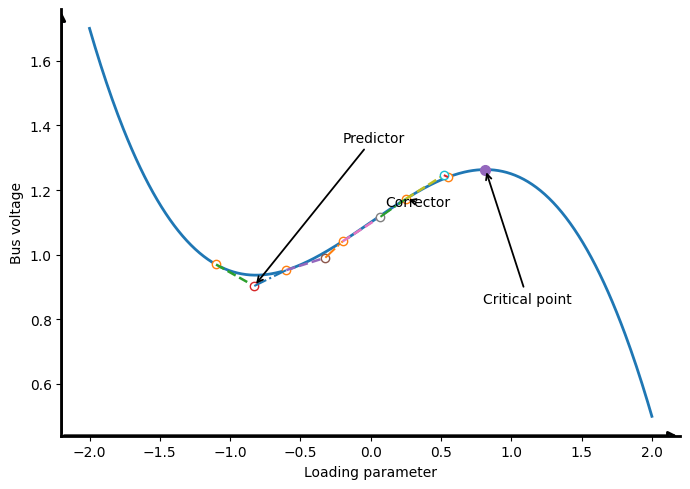

In [2]:
# Create a predictor–corrector style diagram (similar to the image) using matplotlib.
# It saves PNG and SVG versions for use in slides.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

# Curve (a generic fold-like curve)
t = np.linspace(-2.0, 2.0, 400)
x = t
y = -0.15*(t**3) + 0.3*t + 1.1  # "Bus voltage" vs "Loading parameter"

fig, ax = plt.subplots(figsize=(7, 5))

# Main solution curve
ax.plot(x, y, linewidth=2)

# Sample continuation points along the curve (downward branch)
t_pts = np.array([-1.1, -0.6, -0.2, 0.25, 0.55])
x_pts = t_pts
y_pts = -0.15*(t_pts**3) + 0.3*t_pts + 1.1

# Plot actual points on the curve (open circles)
ax.plot(x_pts, y_pts, linestyle="none", marker="o", markersize=6, markerfacecolor="white")

# Predictor steps: straight tangential steps
def tangent_at(t0):
    # dy/dx from param derivative (since x=t): dy/dt
    dydt = -0.45*(t0**2) + 0.3
    dxdt = 1.0
    v = np.array([dxdt, dydt], dtype=float)
    v = v / np.linalg.norm(v)
    return v

h = 0.28  # step length for predictor arrows
pred_segments = []
corr_segments = []

for i in range(len(t_pts)-1):
    t0 = t_pts[i]
    p0 = np.array([x_pts[i], y_pts[i]])
    v = tangent_at(t0)
    p_pred = p0 + h * v  # predictor point (off-curve)
    pred_segments.append((p0, p_pred))

    # "Corrector": project predictor back onto curve by using next true point (visual only)
    p_corr = np.array([x_pts[i+1], y_pts[i+1]])
    corr_segments.append((p_pred, p_corr))

# Draw predictor dashed lines with open circles at the end
for (p0, p1) in pred_segments:
    ax.plot([p0[0], p1[0]], [p0[1], p1[1]], linestyle="--", linewidth=1.8)
    ax.plot(p1[0], p1[1], marker="o", markersize=6, markerfacecolor="white")

# Draw corrector segments (dash-dot)
for (p1, p2) in corr_segments:
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], linestyle="-.")

# Mark a "critical point" (approximate fold point where dy/dx ~ 0)
# dy/dt = -0.45 t^2 + 0.3; set ~0 -> t ~ sqrt(0.3/0.45) ~ 0.816
t_c = np.sqrt(0.3/0.45)
x_c = t_c
y_c = -0.15*(t_c**3) + 0.3*t_c + 1.1
ax.plot(x_c, y_c, marker="o", markersize=7)

# Annotations
ax.annotate("Predictor", xy=pred_segments[0][1], xytext=(-0.2, 1.35),
            arrowprops=dict(arrowstyle="->", lw=1.3))
ax.annotate("Corrector", xy=corr_segments[2][1], xytext=(0.1, 1.15),
            arrowprops=dict(arrowstyle="->", lw=1.3))
ax.annotate("Critical point", xy=(x_c, y_c), xytext=(0.8, 0.85),
            arrowprops=dict(arrowstyle="->", lw=1.3))

# Axes labels and look
ax.set_xlabel("Loading parameter")
ax.set_ylabel("Bus voltage")

# Draw thick axes with arrowheads (stylized)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)
ax.tick_params(axis="both", which="both", direction="out")

# Add axis arrows
ax.add_patch(FancyArrowPatch((xmin, ymin), (xmax, ymin), arrowstyle="-|>", mutation_scale=12, lw=2))
ax.add_patch(FancyArrowPatch((xmin, ymin), (xmin, ymax), arrowstyle="-|>", mutation_scale=12, lw=2))

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

fig.tight_layout()

png_path = "/mnt/data/predictor_corrector_continuation.png"
svg_path = "/mnt/data/predictor_corrector_continuation.svg"
fig.savefig(png_path, dpi=300, bbox_inches="tight")
fig.savefig(svg_path, bbox_inches="tight")

png_path, svg_path
